In [3]:
# Подключение библиотек
import os 
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf

In [4]:
# определние рамки для храния масок и изображений
framObjTrain = {'img' : [],
           'mask' : []
          }

# определение функции загрузки данных 
def LoadData( frameObj = None, imgPath = None, maskPath = None, shape = 128):
    imgNames = os.listdir(imgPath)
    
    names = []
    maskNames = []
    unames = []
    
    for i in range(len(imgNames)):
        unames.append(imgNames[i].split('_')[0])
    
    unames = list(set(unames))
    
    for i in range(len(unames)):
        names.append(unames[i])
        maskNames.append(unames[i])
    
    imgAddr = imgPath + '/'
    maskAddr = maskPath + '/'
    
    for i in range (len(names)):
        img = plt.imread(imgAddr + names[i])
        mask = plt.imread(maskAddr + maskNames[i])
        
        img = cv2.resize(img, (shape, shape)) 
        mask = cv2.resize(mask, (shape, shape))
        
        frameObj['img'].append(img)
        frameObj['mask'].append(mask)
        
    return frameObj


In [5]:
framObjTrain = LoadData( framObjTrain, imgPath = 'images/train/satellite'
                        , maskPath = 'images/train/vector'
                         , shape = 128)

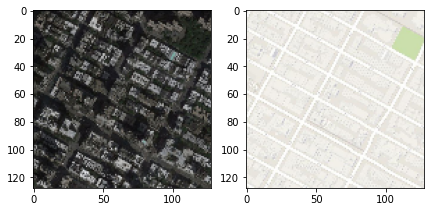

In [6]:
# Отображение данных, загруженных нашей функцией
plt.figure(figsize = (7, 5))
plt.subplot(1,2,1)
plt.imshow(framObjTrain['img'][1])
plt.subplot(1,2,2)
plt.imshow(framObjTrain['mask'][1])
plt.show()

In [7]:
# выполним фактически 2 свертки
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    # Первая свертка 
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)

    # Вторая свертка 
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x

# Определим Unet - модель
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # Определим пути кодирования
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)

    # Определим пути декодирования
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [8]:
# Создание экземпляра модели
inputs = tf.keras.layers.Input((128, 128, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [9]:
retVal = myTransformer.fit(np.array(framObjTrain['img']), np.array(framObjTrain['mask']), epochs = 50, verbose = 0)

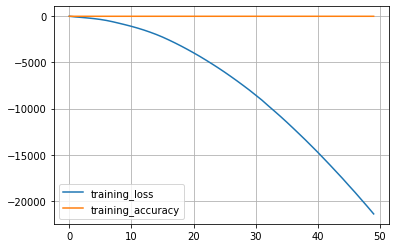

In [10]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [19]:
# функция для получения 16 прогнозов 
def predict16(valMap, model, shape=256):
    # получение и обработка данных val
    img = valMap['img']
    mask = valMap['mask']
    mask = mask[0:16]

    imgProc = img[0:16]
    imgProc = np.array(img)

    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0], predictions[i,:,:,1],predictions[i,:,:,2]))

    return predictions, imgProc, mask

def Plotter(img, predMask, groudTruth):
    plt.figure(figsize=(20,10))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('Изображение территории')

# добавление фильтра вектора на изображение здесь
    filter = np.array([[-1,-1,-1], [-1,-1,-1]])
    imgSharpen = cv2.filter2D(predMask, -1, filter)

    plt.subplot(1,3,3)
    plt.imshow(groudTruth)
    plt.title('Актуальная маска местности')
    

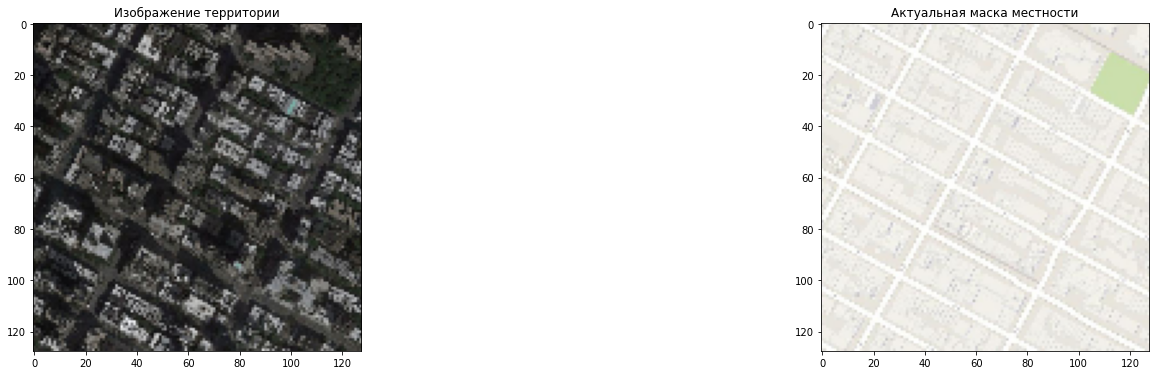

In [20]:
sixteenPrediction, actuals, masks = predict16(framObjTrain, myTransformer)
Plotter(actuals[1], sixteenPrediction[1], masks[1])

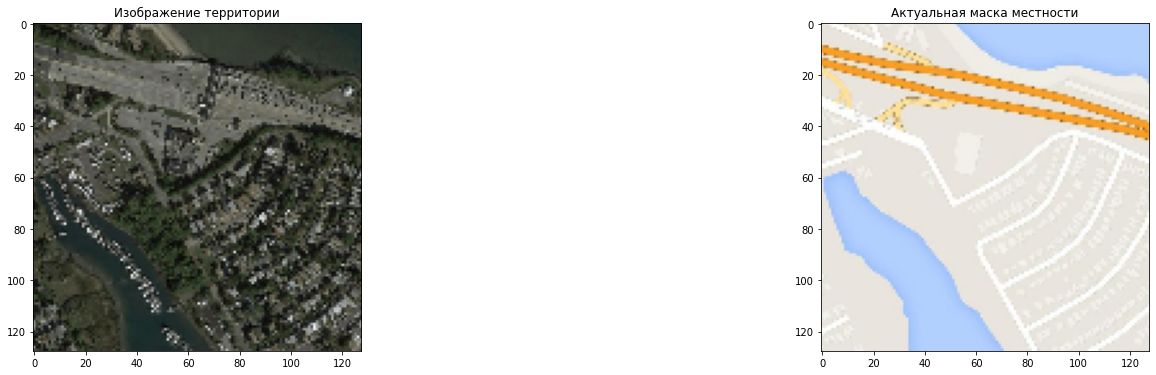

In [21]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

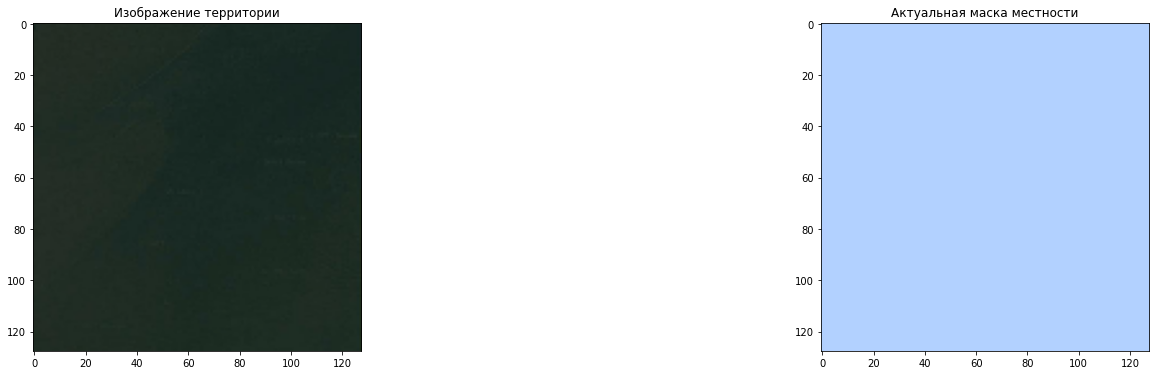

In [22]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

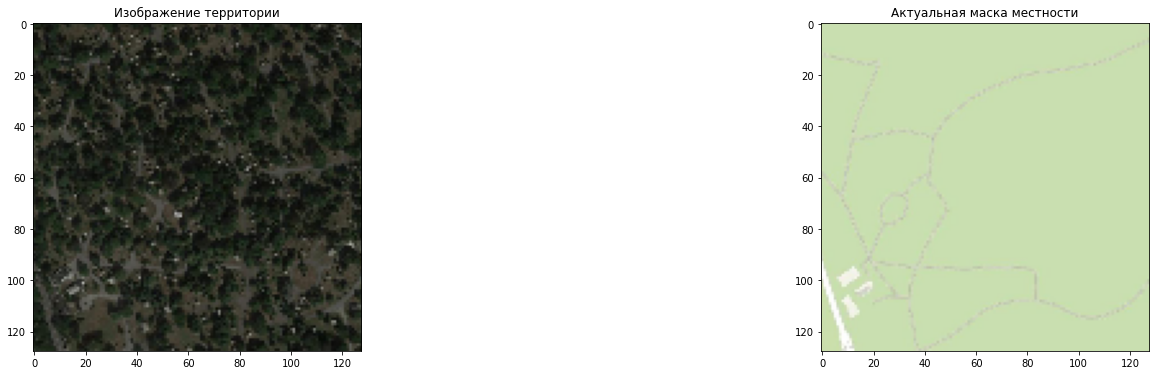

In [23]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

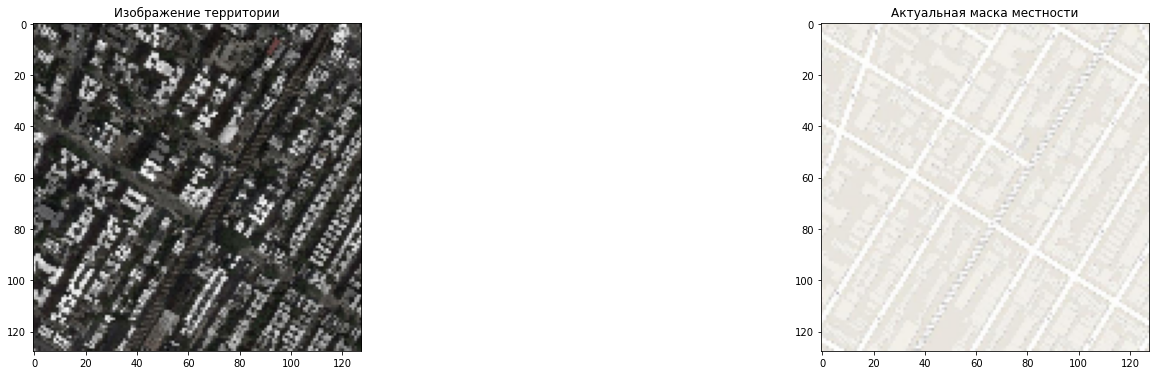

In [24]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])

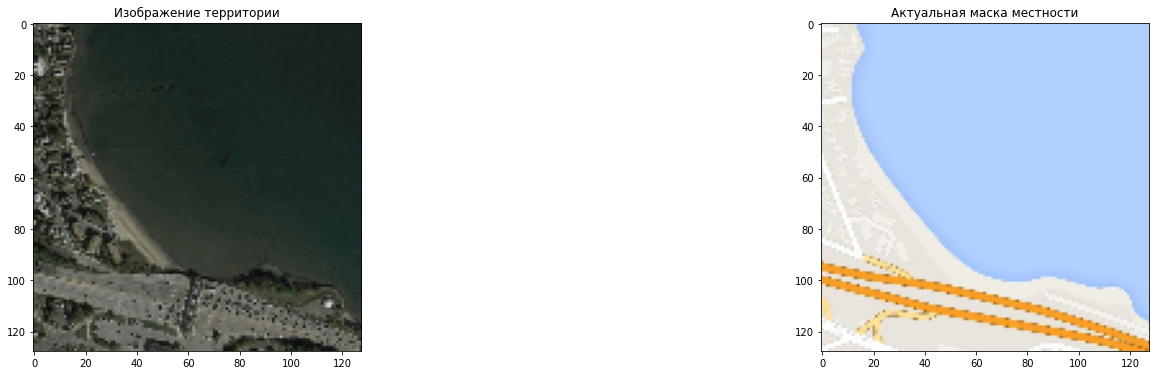

In [25]:
Plotter(actuals[6], sixteenPrediction[6], masks[6])

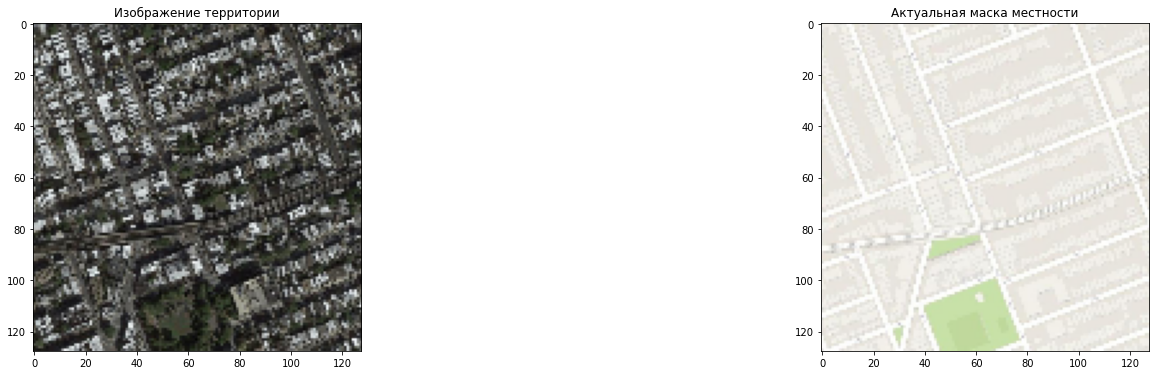

In [26]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

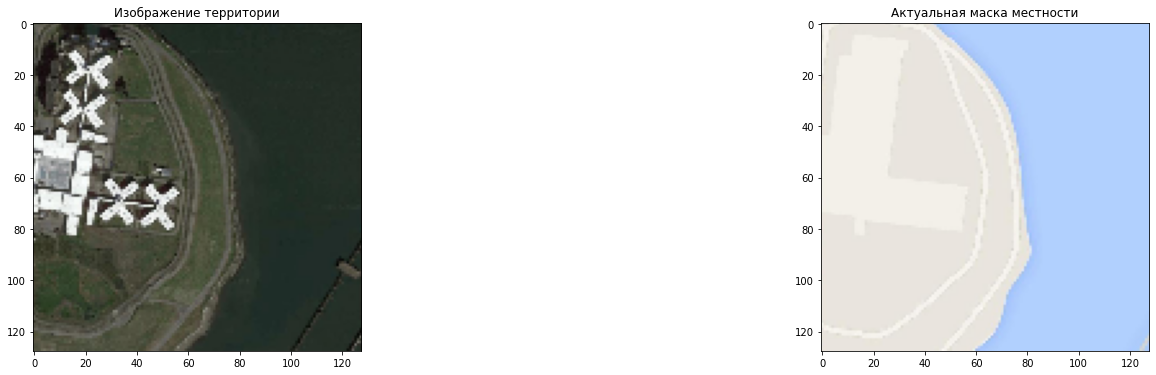

In [27]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])

In [ ]:
myTransformer.save('KP.h5')